In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pickle
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.corpus import stopwords
from nltk import PorterStemmer,SnowballStemmer
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm_notebook as tqdm
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from PIL import Image
import math
import datetime

In [2]:
tr_var=pd.read_csv('training_variants')
tr_text=pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
tr_var.head()
print('Train variation Shape: ',tr_var.shape)
print('Train Text shape: ',tr_text.shape)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


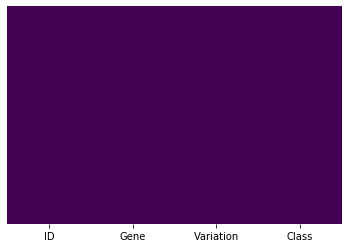

In [3]:
#checking for null values:
plt.figure(figsize=(6,4))
sns.heatmap(data=tr_var.isnull(),cbar=False,yticklabels=False,cmap='viridis')
plt.show()

<h3>1.Exploratory Data Analysis..</h3> 

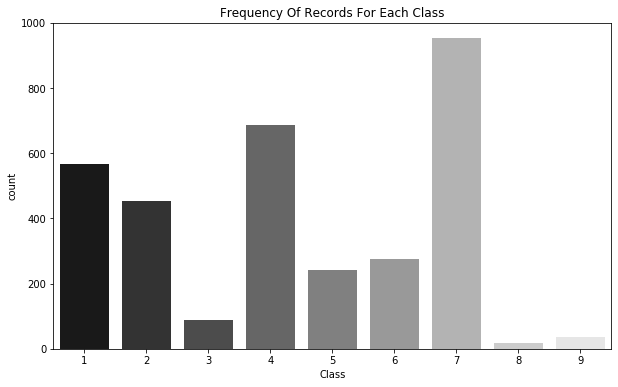

In [4]:
plt.figure(figsize=(10,6))
sns.countplot(x=tr_var['Class'],palette='gist_gray')
plt.title('Frequency Of Records For Each Class')
plt.show()

#### >> records corresponding to classes 3,8,9 are very few ,stratified sampling and balancing the data should be considered for better results.

### 1.1 univariate analysis

#### 1.1.1.Genes and Variation

In [724]:
tr_var['Gene'].describe()

count      3321
unique      264
top       BRCA1
freq        264
Name: Gene, dtype: object

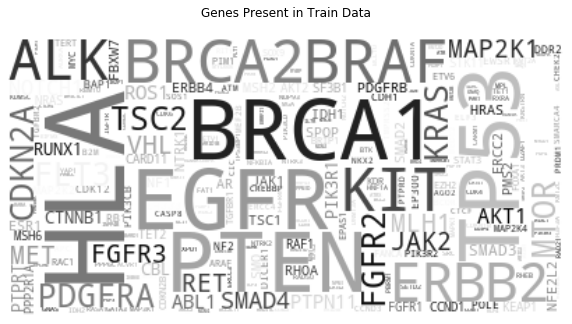

In [10]:
G=""
for genes in tr_var['Gene'].value_counts().index:
    G+=genes+" "
    
wcg=WordCloud(background_color='white',max_words=len(G.split()),colormap='gist_gray_r').generate(G.strip())
plt.figure(figsize=(10,10))
plt.imshow(wcg,interpolation='bilinear')
plt.axis('off')
plt.title('Genes Present in Train Data\n')
plt.show()

In [11]:
tr_var['Variation'].describe()

count                     3321
unique                    2996
top       Truncating Mutations
freq                        93
Name: Variation, dtype: object

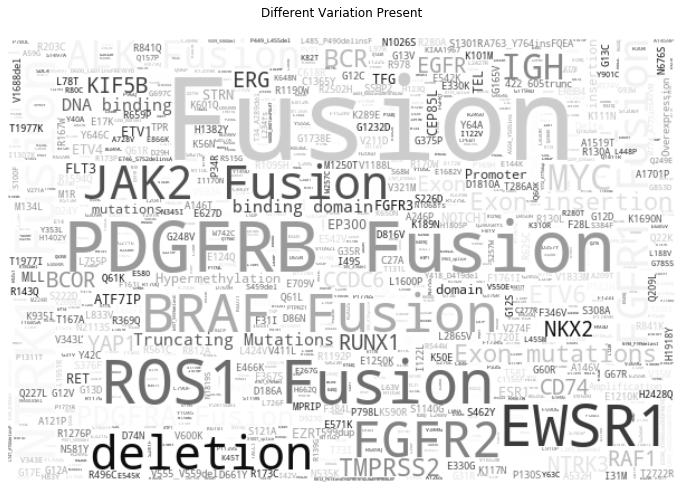

In [13]:
V=""
for vrtion in tr_var['Variation'].value_counts().index:
    V+=vrtion+" "
    
wcv=WordCloud(width=600,height=400,background_color='white',\
              max_words=len(V.split()),colormap='gist_gray_r').generate(V.strip())
plt.figure(figsize=(12,9))
plt.imshow(wcv,interpolation='bilinear')
plt.axis('off')
plt.title('Different Variation Present\n')
plt.show()

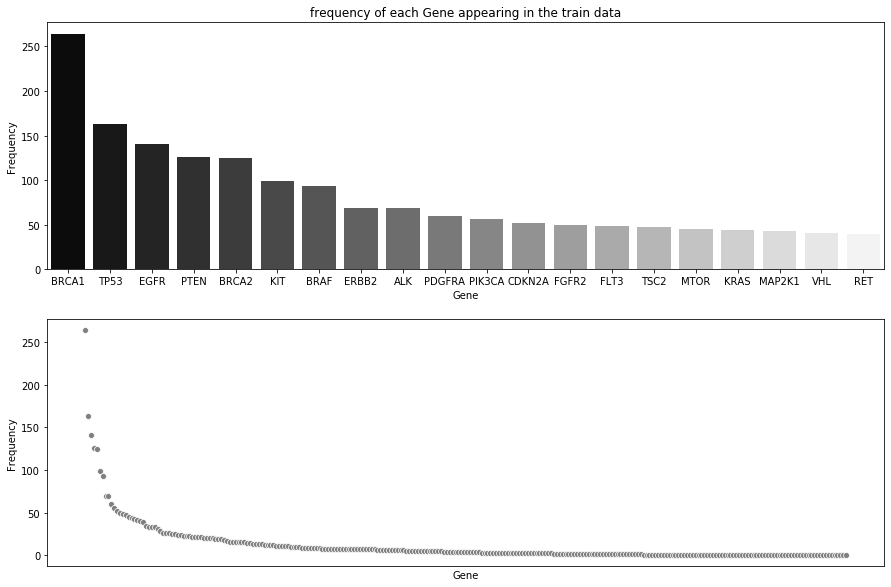

Description of the frequency of each gene 
 count    264.000000
mean      12.579545
std       26.561524
min        1.000000
25%        1.000000
50%        4.000000
60%        6.000000
75%       11.250000
80%       16.000000
90%       27.400000
95%       48.700000
100%     264.000000
max      264.000000
Name: ID, dtype: float64


In [33]:
gene_tr=tr_var.groupby('Gene')['ID'].count().sort_values(ascending=False).reset_index()
fig,ax=plt.subplots(2,1,figsize=(15,10))
sns.barplot(x='Gene',y='ID',data=gene_tr[:20],palette='gist_gray',ax=ax[0])
ax[0].set_title("frequency of each Gene appearing in the train data")
ax[0].set_ylabel('Frequency')

sns.scatterplot(x='Gene',y='ID',data=gene_tr,ax=ax[1],color='gray')
ax[1].set_ylabel("Frequency")
ax[1].set_xticks([],[])
plt.show()

print("Description of the frequency of each gene \n",\
      gene_tr['ID'].describe(percentiles=[0.25,0.5,0.60,0.75,0.80,0.90,0.95,1]))

#### >>we have 264 categories of genes in the train data . 50% of the Genes appears less than 4 times in the train data.

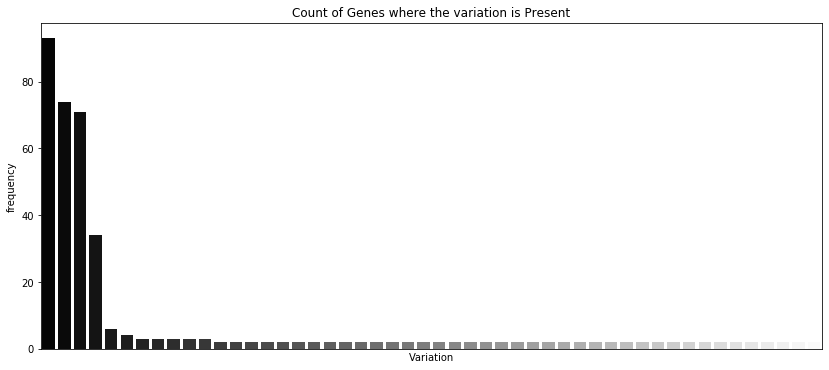


Top 10 variations are
Truncating Mutations,Deletion,Amplification,Fusions,Overexpression,G12V,E17K,T58I,Q61L,Q61R


In [41]:
var_tr=tr_var.groupby('Variation')['ID'].count().sort_values(ascending=False).reset_index()
plt.figure(figsize=(14,6))
sns.barplot(x='Variation',y='ID',data=var_tr[:50],palette='gist_gray')
plt.ylabel("frequency")
plt.xticks([],[])
plt.title("Count of Genes where the variation is Present")
plt.show()

print("\nTop 10 variations are")
print(",".join(var for var in list(var_tr['Variation'][:10].values)))

#### >>some variations are occuring very frequently whereas others are occuring less than 5

### 1.2 Bivariate Analysis

#### 1.2.1 Class and Gene.

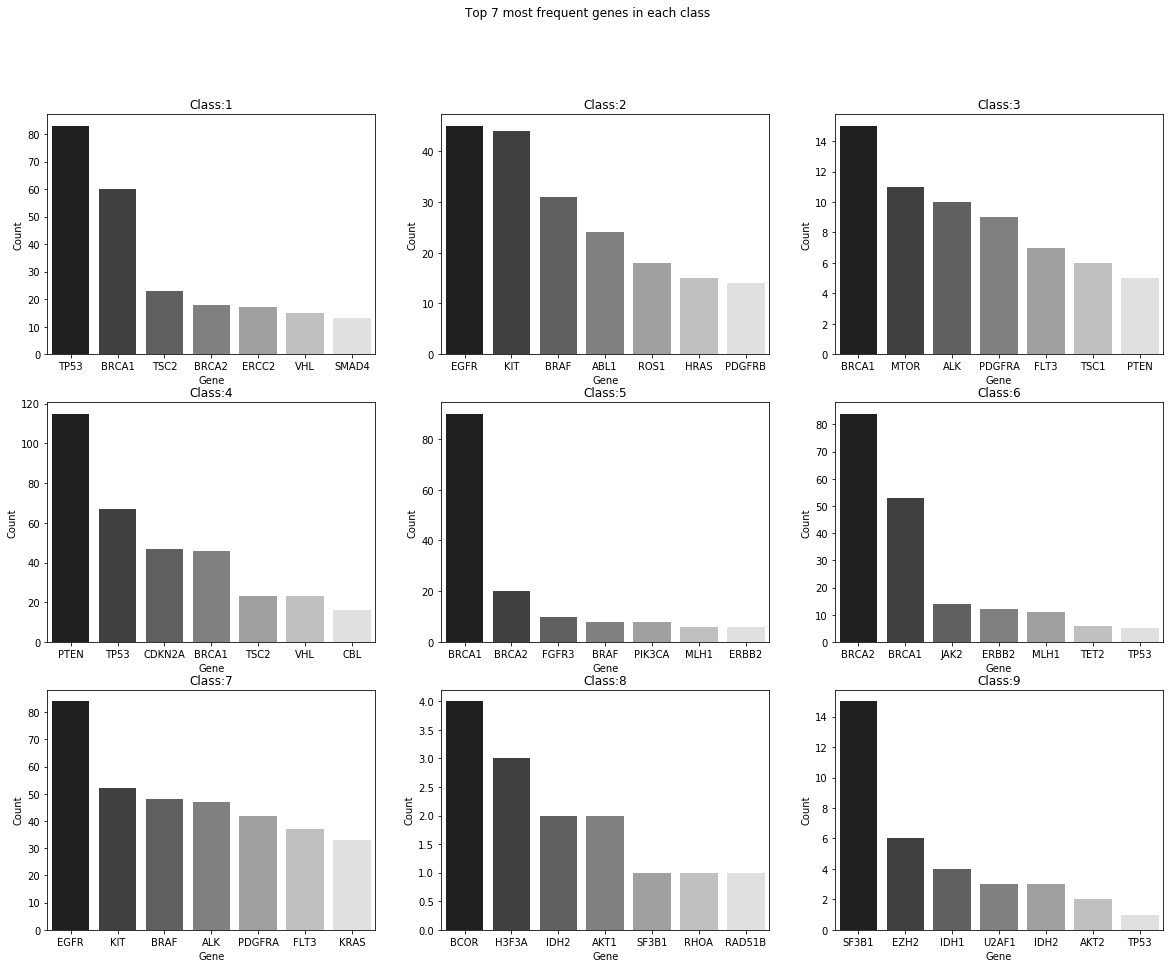

In [42]:
fig,ax=plt.subplots(3,3,figsize=(20,15))
plt.suptitle("Top 7 most frequent genes in each Class")
for i in range(3):
    for j in range(3):
        to_b_p=tr_var[tr_var['Class']==(i*3+j+1)].groupby('Gene')['ID'].count()\
                        .sort_values(ascending=False).reset_index()[:7]
        sns.barplot(x='Gene',y='ID',data=to_b_p,ax=ax[i][j],palette='gist_gray')
        ax[i][j].set_ylabel('Count')
        ax[i][j].set_title("Class:"+str(i*3+j+1))


In [46]:
for i in range(9):
    print("Number Of unique Genes in Class "\
          +str(i+1)+"-->"+str(tr_var[tr_var['Class']==i+1]['Gene'].unique().shape[0]))
    

Number Of unique Genes in Class 1-->142
Number Of unique Genes in Class 2-->96
Number Of unique Genes in Class 3-->26
Number Of unique Genes in Class 4-->92
Number Of unique Genes in Class 5-->48
Number Of unique Genes in Class 6-->56
Number Of unique Genes in Class 7-->108
Number Of unique Genes in Class 8-->12
Number Of unique Genes in Class 9-->10


#### 1.2.2 Class and Variation.

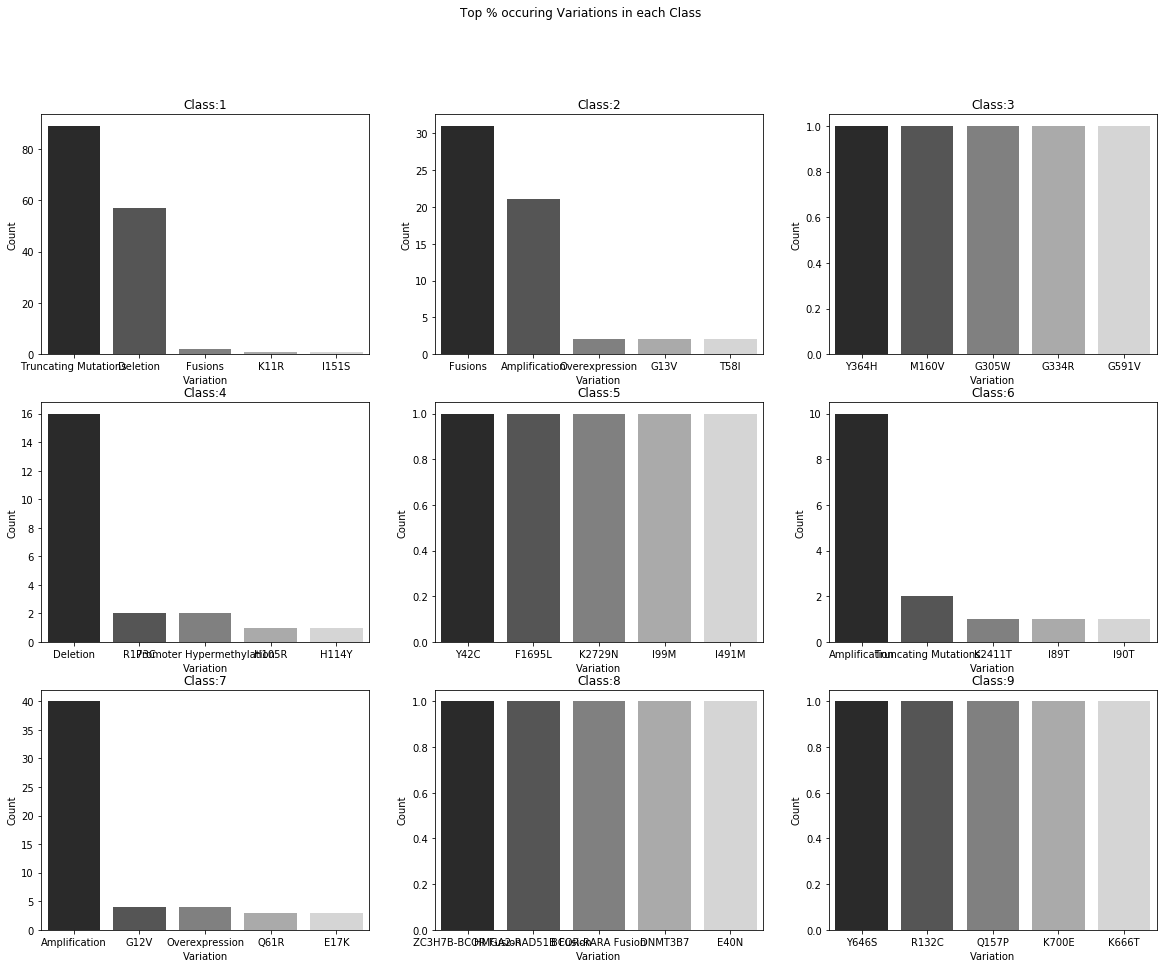

In [50]:
fig,ax=plt.subplots(3,3,figsize=(20,15))
plt.suptitle('Top % occuring Variations in each Class')
for i in range(3):
    for j in range(3):
        to_b_p=tr_var[tr_var['Class']==(i*3+j+1)].groupby('Variation')['ID'].count()\
        .sort_values(ascending=False).reset_index()[:5]
        
        sns.barplot(x='Variation',y='ID',data=to_b_p,ax=ax[i][j],palette='gist_gray')
        ax[i][j].set_ylabel('Count')
        ax[i][j].set_title("Class:"+str(i*3+j+1))

In [51]:
#Exploring class 3,5,8,9 .

x_ax_3=tr_var[tr_var['Class']==3]['Variation'].value_counts().index
y_ax_3=tr_var[tr_var['Class']==3]['Variation'].value_counts().values

x_ax_5=tr_var[tr_var['Class']==5]['Variation'].value_counts().index
y_ax_5=tr_var[tr_var['Class']==5]['Variation'].value_counts().values

x_ax_8=tr_var[tr_var['Class']==8]['Variation'].value_counts().index
y_ax_8=tr_var[tr_var['Class']==8]['Variation'].value_counts().values

x_ax_9=tr_var[tr_var['Class']==9]['Variation'].value_counts().index
y_ax_9=tr_var[tr_var['Class']==9]['Variation'].value_counts().values

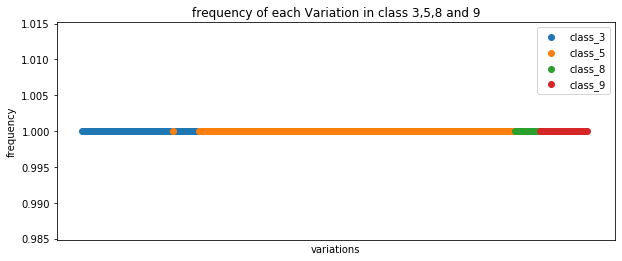

In [52]:
plt.figure(figsize=(10,4))
plt.scatter(x=x_ax_3,y=y_ax_3,label='class_3')
plt.scatter(x=x_ax_5,y=y_ax_5,label='class_5')
plt.scatter(x=x_ax_8,y=y_ax_8,label='class_8')
plt.scatter(x=x_ax_9,y=y_ax_9,label='class_9')
plt.ylabel("frequency")
plt.xlabel("variations")
plt.xticks([],[])
plt.legend()
plt.title("frequency of each Variation in class 3,5,8 and 9")
plt.show()

#### >> In each of the class 3,5,8 and 9 the variation if exits,it appear only once.

In [53]:
for i in range(9):
    print("Number Of unique variation in Class "\
          +str(i+1)+"-->"+str(tr_var[tr_var['Class']==i+1]['Variation'].unique().shape[0]))


Number Of unique variation in Class 1-->423
Number Of unique variation in Class 2-->399
Number Of unique variation in Class 3-->89
Number Of unique variation in Class 4-->669
Number Of unique variation in Class 5-->242
Number Of unique variation in Class 6-->265
Number Of unique variation in Class 7-->889
Number Of unique variation in Class 8-->19
Number Of unique variation in Class 9-->37


#### 1.2.3. Feature interaction between Gene and variation

In [738]:
g_V=tr_var['Gene']+tr_var['Variation']
g_V.describe()

count          3321
unique         3321
top       ALKL1198P
freq              1
dtype: object

#### >>Gene+Variation is a unique pair.   

Number Of Different Variations Present in each Gene



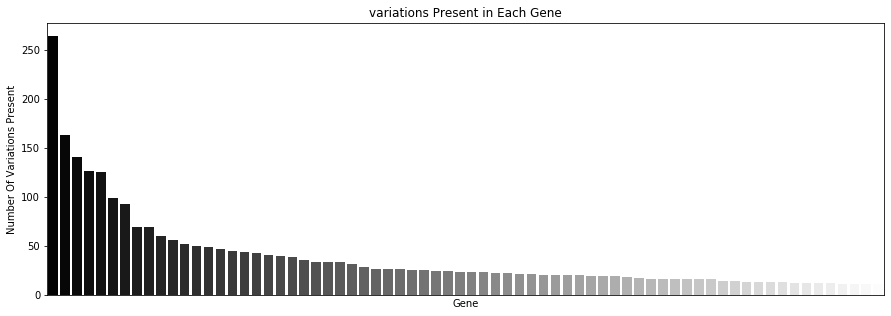


Top 10 Genes are: 
BRCA1,TP53,EGFR,PTEN,BRCA2,KIT,BRAF,ERBB2,ALK,PDGFRA

Description:
         Variation
count  264.000000
mean    12.579545
std     26.561524
min      1.000000
25%      1.000000
50%      4.000000
75%     11.250000
max    264.000000


In [63]:
print('Number Of Different Variations Present in each Gene\n')
gene_var=tr_var.groupby('Gene')['Variation'].count().sort_values(ascending=False).reset_index()

plt.figure(figsize=(15,5))
sns.barplot(x='Gene',y='Variation',data=gene_var[:70],palette='gist_gray',)
plt.xticks([],[])
plt.ylabel("Number Of Variations Present")
plt.title('variations Present in Each Gene')
plt.show()

print("\nTop 10 Genes are: ")
print(",".join(gen for gen in list(gene_var['Gene'][:10].values)))
print('\nDescription:\n',gene_var.describe())



#### >>There  are a few genes that are having a large number of variations in them,75% of the genes has less than 12 variation.

In [64]:
#MERGING THE TWO DATAFRAMES 
train=pd.merge(left=tr_var,right=tr_text,on='ID',how='inner')

### 1.3 Analyzing Text

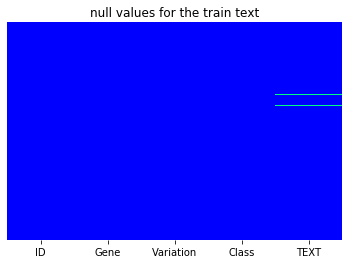

In [65]:
#checking for the null values:
sns.heatmap(train.isnull(),cbar=False,yticklabels=False,cmap='winter')
plt.title("null values for the train text")
plt.show()

In [66]:
#replacing the null text with the gene+variation field
train.loc[train['TEXT'].isnull(),'TEXT']=train['Gene']+' '+train['Variation']

In [73]:
cl_text=""
for text in train['TEXT'].values:
    for word in text.split(' '):
        cl_text+=word+" "
cl_text=cl_text.rstrip()
    

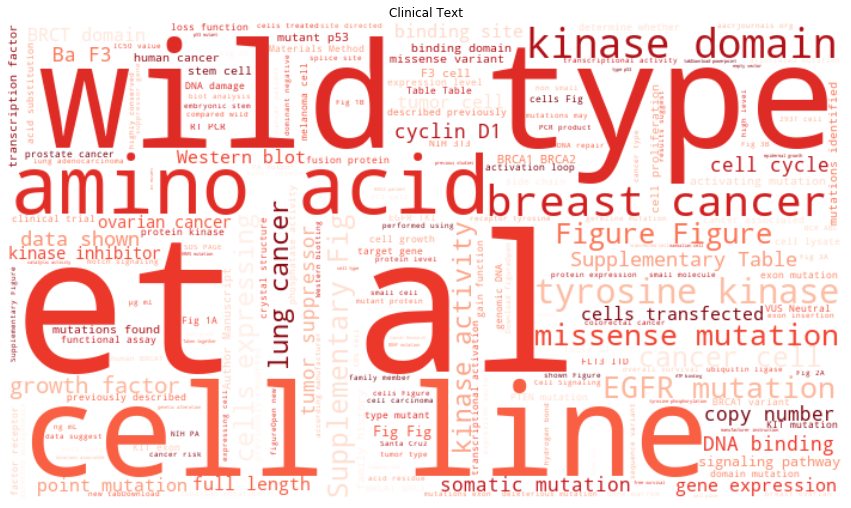

In [78]:
wc=WordCloud(height=400,width=700,background_color='white',colormap='Reds').generate(cl_text)
plt.figure(figsize=(15,10))
plt.axis('off')
plt.title('Clinical Text')
plt.imshow(wc,interpolation='bilinear')
plt.show()

In [71]:
print(train['TEXT'][1])

 Abstract Background  Non-small cell lung cancer (NSCLC) is a heterogeneous group of disorders with a number of genetic and proteomic alterations. c-CBL is an E3 ubiquitin ligase and adaptor molecule important in normal homeostasis and cancer. We determined the genetic variations of c-CBL, relationship to receptor tyrosine kinases (EGFR and MET), and functionality in NSCLC.  Methods and Findings  Using archival formalin-fixed paraffin embedded (FFPE) extracted genomic DNA, we show that c-CBL mutations occur in somatic fashion for lung cancers. c-CBL mutations were not mutually exclusive of MET or EGFR mutations; however they were independent of p53 and KRAS mutations. In normal/tumor pairwise analysis, there was significant loss of heterozygosity (LOH) for the c-CBL locus (22%, n = 8/37) and none of these samples revealed any mutation in the remaining copy of c-CBL. The c-CBL LOH also positively correlated with EGFR and MET mutations observed in the same samples. Using select c-CBL som

#### >>Clinical Text is taken from the research papers we have to remove certain citations (in square brackets []) and words like Table,Figure,et al.

#### 1.3.1 Analysis of Text Length.

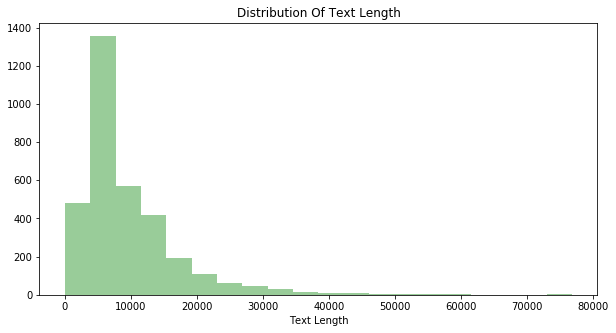

count     3321.000000
mean      9551.113821
std       7849.193294
min          2.000000
25%       4733.000000
50%       6871.000000
75%      11996.000000
max      76782.000000
Name: Length, dtype: float64


In [91]:
train['Length']=train['TEXT'].apply(lambda tx:len(tx.split()))
plt.figure(figsize=(10,5))
sns.distplot(train['Length'].values,bins=20,kde=False,color='green')
plt.title('Distribution Of Text Length')
plt.xlabel('Text Length')
plt.show()

print(train['Length'].describe())

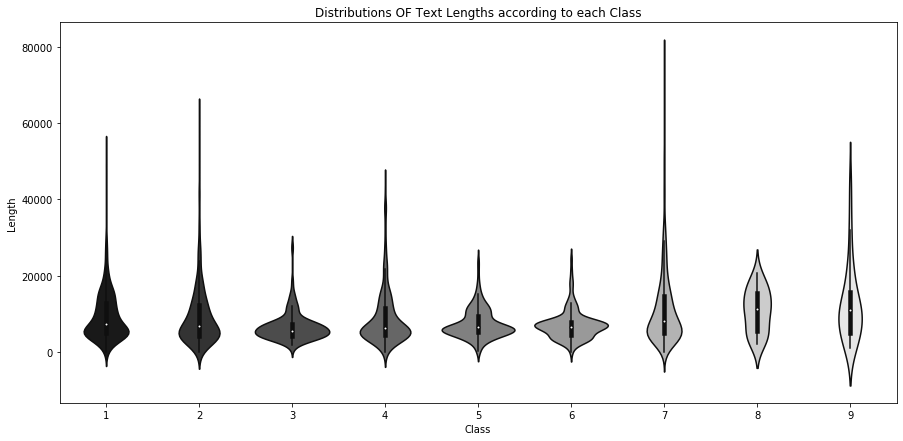

In [164]:
plt.figure(figsize=(15,7))
sns.violinplot(x='Class',y='Length',data=train,palette='gist_gray')
plt.title('Distributions OF Text Lengths according to each Class')
plt.show()

#### >> The average length of clinical text for a given datapoint is 9550 words.
#### >> The Text Length is not looking like a distinguishing feature for classes as every class is having the same distribution of text length

#### 1.3.2 Duplicates in the Clinical Text

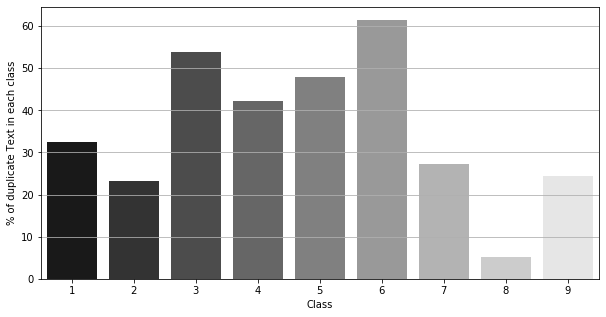

In [94]:
dupl_percentage=[]
lab=[]
for C in range(1,10,1):
    cls=train[train['Class']==C]
    dup_cls=train[train['Class']==C].duplicated(subset=['TEXT'],keep='first')
    dupl_percentage.append(np.round((cls[dup_cls].shape[0]*100)/cls.shape[0],2))
    lab.append(C)
plt.figure(figsize=(10,5))
plt.grid()
sns.barplot(x=lab,y=dupl_percentage,palette='gist_gray')
plt.ylabel('% of duplicate Text in each class')
plt.xlabel('Class')
plt.show()

#### >>class 6,3,5,4 having more than 40% of their clinical text as duplicate. So Text Analysis will be done on unique clinical Text only.

In [95]:
#collecting the complete text in the text_df DataFrame...
total_text=[]
for tx in train['TEXT'].values:
    total_text.append(tx)

text_df=pd.DataFrame(data=total_text,columns=['TEXT'])
text_df.describe()

,TEXT
count,3321
unique,1925
top,The PTEN (phosphatase and tensin homolog) phos...
freq,53


### 2.Frequency encoding for the categorical variables 'gene' and 'variation'.

In [122]:
mpr1=train.groupby('Gene').size()/train.shape[0]

train.loc[:,'Gene_Freq']=train['Gene'].map(mpr1)

mpr2=train.groupby('Variation').size()/train.shape[0]

train.loc[:,'Variation_Freq']=train['Variation'].map(mpr2)

### 3. Text Preprocessing

In [96]:
#adding some words to the stopwords
m_spwrd=set(stopwords.words('english'))
m_spwrd.add('fig')
m_spwrd.add('figure')
m_spwrd.add('table')


def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def Text_Preprocess(tx):
    tx=tx.lower()
    tx=decontracted(tx)
    
    tx=re.sub(r'%',r'percent',tx)
    tx=re.sub(r'-',r"_",tx)
    
    #removing the citations
    tx=re.sub(r'\[.*?\]',r" ",tx)
    
    
    #removing punctuations..
    tx=re.sub(r'[^A-Za-z]',r' ',tx)
    
    #removing stopwords
    tx=" ".join(wrds.strip() for wrds in tx.split() if wrds not in m_spwrd).strip()
    
    #Lemmetization
    tx=" ".join(WordNetLemmatizer().lemmatize(wrds) for wrds in tx.split())
    
    #removing the words of length 1 or 2 as they will have no meaning at all.
    tx=re.sub(r'\b\w{1,2}\b',r'',tx)

    return tx.strip()


In [97]:
pr_txts=[]
for tx in tqdm(text_df['TEXT'].values):
    pr_txts.append(Text_Preprocess(tx))

text_df['TEXT']=pr_txts

#### 2.1 Observations on the unigrams

In [98]:
def Analyze_words(TEXT_clm):
    
    non_dup_text=text_df[~TEXT_clm.duplicated(keep='first')]['TEXT']

    Description=""
    for text in non_dup_text.values:
        for word in text.split(' '):
            Description+=word+" "
    Description=Description.rstrip()

    dict_w=dict(Counter(Description.split()))
    list_w=(sorted(dict_w.items(),key=lambda x:x[1],reverse=True))

    print("total Unique Words in Whole data ",len(list_w))
    wdf=pd.DataFrame(data=list_w,columns=['Word','Frequency'])
    plt.figure(figsize=(17,15))
    sns.barplot(x='Frequency',y='Word',data=wdf[:60],palette='GnBu_d')
    plt.show()
    return Description


2020-09-06 12:37:09.411757
total Unique Words in Whole data  83599


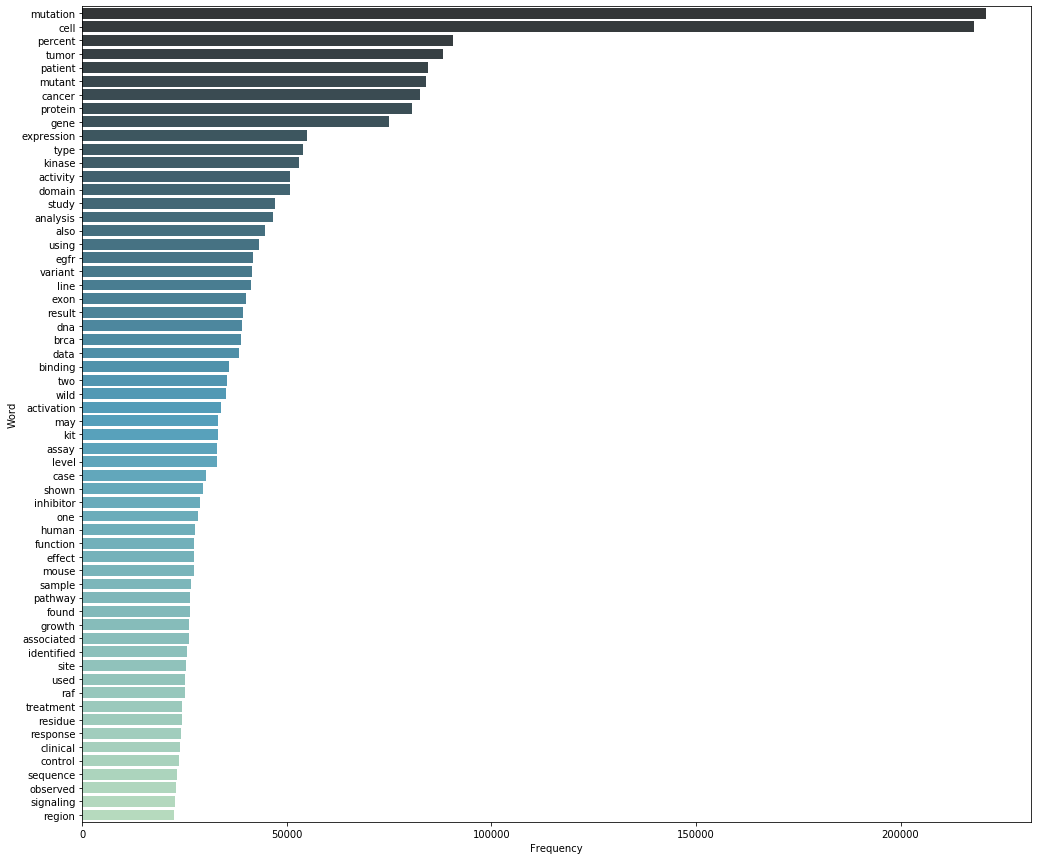

2020-09-06 12:37:20.246324


In [99]:
print(datetime.datetime.now())

Description=Analyze_words(text_df['TEXT'])

print(datetime.datetime.now())

#### >> 50 of the top words appear in almost every clinical Text. We will remove these top unigrams to remove ambuguity.

#### 2.2. Removing The Top Frequent Unigrams

In [102]:
#REMOVING THE top 0.15% most frequent UNIGRAMS 

non_dup_text=text_df[~text_df['TEXT'].duplicated(keep='first')]['TEXT']

tf_u=TfidfVectorizer(ngram_range=(1,1),min_df=1)
tf_u.fit(non_dup_text.values)

u_idf=dict(zip(tf_u.get_feature_names(),tf_u.idf_))
l_idf_u=sorted(u_idf.items(),key=lambda x:x[1],reverse=False)

print("Total Unique Unigrams Collected from train data ",len(l_idf_u))

remove_ungm=[]
rem_frac=math.floor(len(l_idf_u)*0.0015)
for i in range(rem_frac):
    remove_ungm.append(l_idf_u[i][0])

print("Unigrams that will get removed from the text ",rem_frac)

#removing top common words from the text....

text_df['TEXT']=text_df['TEXT'].apply(lambda x:" ".join(wrds for wrds in x.split() if wrds not in remove_ungm))

Total Unique Unigrams Collected from train data  83599
Unigrams that will get removed from the text  125


total Unique Words in Whole data  83474


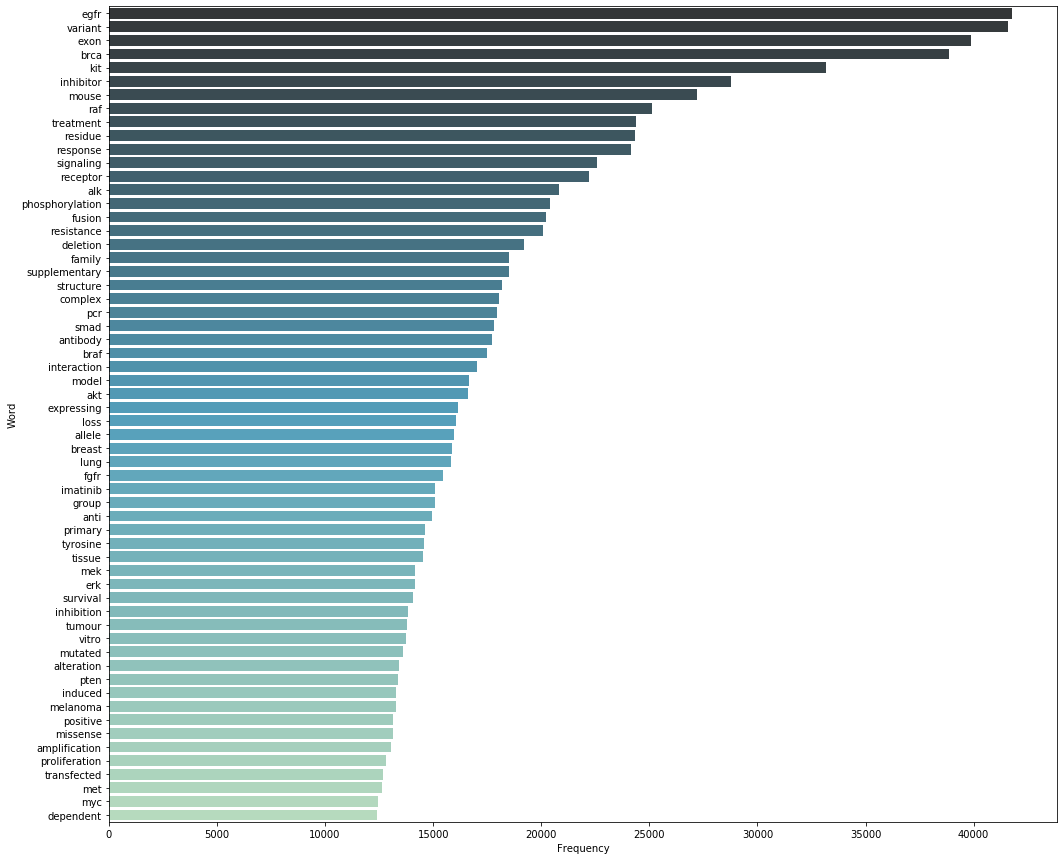

In [103]:
Description=Analyze_words(text_df["TEXT"])

#### >> We can us the "remove_ungm" list for the preprocessing of the Test data later .

#### 2.3. Biagram analysis

In [104]:
tf_b=TfidfVectorizer(ngram_range=(2,2))
tf_b.fit(non_dup_text.values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(2, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [105]:
d_bg=dict(zip(tf_b.get_feature_names(),tf_b.idf_))
list_bgms=sorted(d_bg.items(),key=lambda x:x[1],reverse=False)
print("Total biagrams Collected ",len(list_bgms))

Total biagrams Collected  2041581


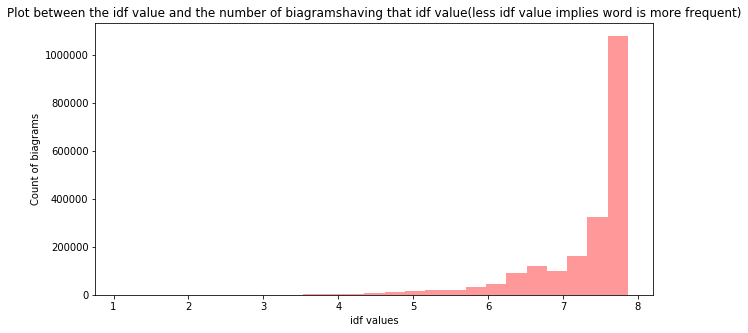

Description of the idf values of biagrams
                 IDF
count   2.041581e+06
mean    7.380253e+00
std     7.334013e-01
min     1.096454e+00
0.001%  1.645388e+00
0.01%   2.256695e+00
1%      4.691480e+00
3%      5.427187e+00
5%      5.854631e+00
10%     6.365457e+00
25%     7.176387e+00
50%     7.869534e+00
75%     7.869534e+00
max     7.869534e+00


In [109]:
big_df=pd.DataFrame(list_bgms,columns=['Biagrams','IDF'])
plt.figure(figsize=(10,5))
sns.distplot(a=big_df['IDF'].values,bins=25,kde=False,color='red')
plt.title("Plot between the idf value and the number of biagrams\
having that idf value(less idf value implies word is more frequent)")
plt.xlabel('idf values')
plt.ylabel('Count of biagrams')
plt.show()

print("Description of the idf values of biagrams")
print(big_df.describe(percentiles=[0.00001,0.0001,0.01,0.03,0.05,0.1,0.25,0.50,0.75]))

#### >>This states that biagrams are less frequent (as obvious)  and even lowest 0.01 percent of biagrams (i.e 204 biagrams) has pretty good idf values.It states that biagrams are not that much frequent like unigrams so we can keep them.

#### 2.4 Creating a mixed vocabulary out of the unigrams ,biagrams and triagrams.Later this same vocabulary will be used to vectorize the text.

In [110]:
import os

if not os.path.isfile('dict_mxgms.txt'):
    ndT=text_df[~text_df['TEXT'].duplicated(keep='first')]['TEXT']
    min_df=[10,5,2]
    max_feature=[3000,1000,25]
    dict_mxgms={}

    for i in tqdm(range(1,4)):
        tf_maxgms=TfidfVectorizer(ngram_range=(i,i),min_df=min_df[i-1],use_idf=True)
        tf_maxgms.fit(ndT.values)
    
        indices=np.argsort(tf_maxgms.idf_)[:max_feature[i-1]]
        for j in indices:
            dict_mxgms[np.array(tf_maxgms.get_feature_names())[j]]=tf_maxgms.idf_[j]
            
    with open('dict_mxgms.txt','wb') as f:
        pickle.dump(dict_mxgms,f)
    
else:
    with open('dict_mxgms.txt','rb') as f:
        dict_mxgms=pickle.load(f)
    

In [111]:
list_mxgms=sorted(dict_mxgms.items(),key=lambda x:x[1],reverse=False)

#collecting words for vocabulary.....
dict_mxgms=dict(list_mxgms)
mxgm_df=pd.DataFrame(list_mxgms,columns=['Grams','Rareness_Measure'])

vocabulary=list(dict_mxgms.keys())

mxgm_df[1000:1020]

,Grams,Rareness_Measure
1000,frozen,2.084172
1001,notion,2.084172
1002,animal,2.084172
1003,exist,2.085709
1004,internal,2.085709
1005,accordance,2.085709
1006,random,2.088791
1007,bioscience,2.088791
1008,serve,2.088791
1009,cruz biotechnology,2.088791


###  3. Vectorizing the Text.

In [112]:
tf_idf=TfidfVectorizer(vocabulary=vocabulary)
tf_idf.fit(text_df['TEXT'].values)
vec_tf_train=tf_idf.transform(text_df['TEXT'].values)
print("Shape of complete text after vectorising ",vec_tf_train.shape)

Shape of complete text after vectorising  (3321, 4025)


In [128]:
train_visualize=pd.DataFrame(data=vec_tf_train.toarray(),columns=list(tf_idf.get_feature_names()))

train_visualize=pd.concat([train[['Gene_Freq','Variation_Freq']],train_visualize],axis=1)
print("Train Data Shape ",train_visualize.shape)

Train Data Shape  (3321, 4027)


In [129]:
train_visualize.head()

,Gene_Freq,Variation_Freq,group,higher,form,highly,due,negative,without,multiple,...,phenylmethylsulfonyl fluoride,transcriptional regulator,anti egfr,lysine residue,antibody directed,nra braf,akt erk,myeloproliferative disorder,chromatin remodeling,see supplemental
0,0.000301,0.028004,0.000000,0.002197,0.006908,0.002215,0.000000,0.000000,0.007138,0.006661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.007528,0.000301,0.033886,0.009726,0.005096,0.014706,0.004998,0.005173,0.015797,0.014743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.007528,0.000301,0.033886,0.009726,0.005096,0.014706,0.004998,0.005173,0.015797,0.014743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.007528,0.000301,0.000000,0.000000,0.000000,0.012075,0.024622,0.101933,0.038910,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.007528,0.000301,0.039485,0.019834,0.005196,0.049981,0.020384,0.015823,0.010738,0.010021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
outputs=train['Class'].values.reshape(-1,1)

### 4.DataSplit and Model implementation.

#### 4.a Scoring that has to improved is multiclass Log-Loss.

In [132]:
from sklearn.model_selection import train_test_split

X_tr,X_ts,y_tr,y_ts=train_test_split(train_visualize,outputs,stratify=outputs,test_size=0.2)

In [133]:
from prettytable import PrettyTable
pt=PrettyTable()
pt.field_names=['Train_Data','Cv_Data']
pt.add_row([X_tr.shape,X_ts.shape])
print(pt)

+--------------+-------------+
|  Train_Data  |   Cv_Data   |
+--------------+-------------+
| (2656, 4027) | (665, 4027) |
+--------------+-------------+




#### 4.1 Logistic regression 

In [134]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,log_loss
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.naive_bayes import MultinomialNB

In [135]:
def Kfold_cv(clf,x,y,k):
    x=np.array(x)
    skf=StratifiedKFold(n_splits=k)
    avg_tr_ll=0
    avg_ts_ll=0
    for train_indices,test_indices in skf.split(x,y):
       
       
        tr_data=x[train_indices]
        ts_data=x[test_indices]
        
        clf.fit(tr_data,y[train_indices])
        
        tr_pprob=clf.predict_proba(tr_data)
        ts_pprob=clf.predict_proba(ts_data)
    
        
        ll_tr=log_loss(y_true=y[train_indices],y_pred=tr_pprob,labels=clf.classes_)
        ll_ts=log_loss(y_true=y[test_indices],y_pred=ts_pprob,labels=clf.classes_)
        avg_tr_ll+=ll_tr
        avg_ts_ll+=ll_ts
        
    #returning the average of train and cv log loss......
    return (np.round(avg_tr_ll/3,5),np.round(avg_ts_ll/3,5))

In [136]:
def htune_logr(train_data,train_output,fold):
    param1=[0.0005,10**-3,0.006,10**-2,0.05,10**-1,1,10,100,1000,10000]
    param2=['l1','l2']


    for j in param2:
        tr_ll=[]
        cv_ll=[]
        for i in param1:
            lr=LogisticRegression(C=i,penalty=j,class_weight='balanced',fit_intercept=True)
            a,b=Kfold_cv(lr,train_data,train_output,fold)
            tr_ll.append(a)
            cv_ll.append(b)
        plt.figure(figsize=(9,5))
        plt.grid(axis='y')
        plt.title("for penalty"+str(j))
        sns.lineplot(x=np.log(param1),y=tr_ll,label="train_data")
        sns.lineplot(x=np.log(param1),y=cv_ll,label="cv_data")
        sns.scatterplot(x=np.log(param1),y=tr_ll)
        plt.xlabel("log(C)")
        plt.ylabel("log_Loss")
        plt.legend()
        plt.show()


In [145]:
def pltcnf(clf,test_data,test_label):
    predictions=np.argmax(clf.predict_proba(test_data),axis=1)+1
    labels=[x+1 for x in range(9)]
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix(y_true=test_label,y_pred=predictions),cmap='Accent',annot=True,fmt='.2f',\
                xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.title('Confusion Matrix For Test Data')
    plt.show()

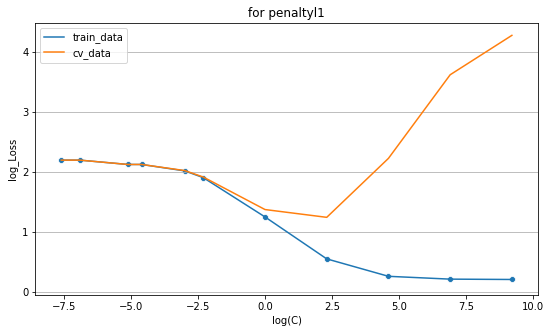

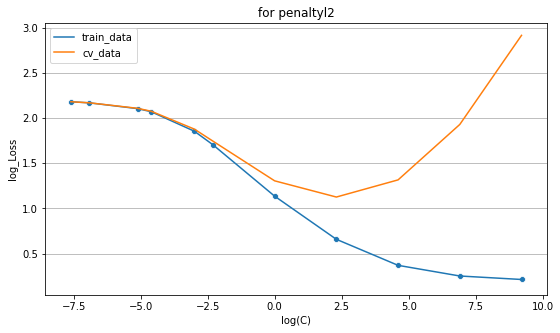

In [138]:
htune_logr(X_tr,y_tr,3)

In [143]:
print("The optimal C is {} \nRegularization is {}".format(10,'l1'))

The optimal C is 10 
Regularization is l1


In [144]:
lr=LogisticRegression(penalty='l2',C=10,class_weight='balanced',multi_class='ovr',fit_intercept=True,n_jobs=2)
lr.fit(X_tr,y_tr)

print("Train Log Loss is ",log_loss(y_pred=lr.predict_proba(X_tr),y_true=y_tr))
print("Cv Log loss is ",log_loss(y_pred=lr.predict_proba(X_ts),y_true=y_ts))

Train Log Loss is  0.6743974223345014
Cv Log loss is  1.1026659282361204


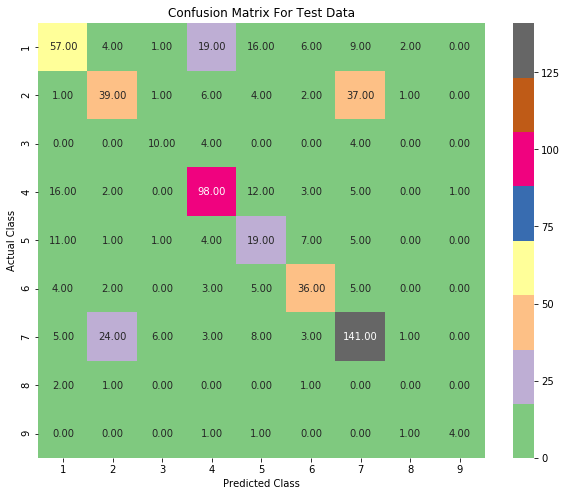

In [146]:
pltcnf(lr,X_ts,y_ts)

#### >>48.6 % of class 2 datapoints are predicted as class 7.

#### 4.2 Using Tfidf-avgw2v (word embedding using gensim.model)

In [147]:
def Tfidf_avgw2v(values,avgw2vmodel,vocab_avgw2v,dim,dict_word_idf,vocab_for_tfidf,which_data,final_list):
    
    #indices of those text which can not be represented using tfidf-avgw2v(vector representation is [0,0,0,0....])
    nr=[]
    
    glob_vec=np.zeros(dim)
    gl_tfidf=0;
    list1=list(values)
    print("converting to tfidf awgw2v for {}....".format(which_data))
    for text in tqdm(list1):
        vec=np.zeros(dim)
        sum_tfidf=0
        for w in text.split():
            if (w in vocab_avgw2v and w in vocab_for_tfidf):
                vec+=avgw2vmodel[w]
                tf=text.count(w)/len(text.split())
                idf=dict_word_idf[w]
                vec*=tf*idf
                glob_vec+=vec
                sum_tfidf+=tf*idf
                gl_tfidf=sum_tfidf
        
        if(sum_tfidf==0):
            nr.append(list1.index(text))
        else:
            final_list.append(vec/sum_tfidf)
    
    avg_vec=glob_vec/gl_tfidf
    
    #mean value subsitution for the text which has representation [0,0,0,0,....]
    for index in nr:
        final_list.insert(index,avg_vec)

In [148]:
#applying on non duplicated preprocessed Text.
doc_corpus=[]
for txt in non_dup_text.values:
    doc_corpus.append(txt.split())
    
w2v_model=Word2Vec(sentences=doc_corpus,size=300,window=4,min_count=5)
vocab_avgw2v=w2v_model.wv.vocab
    
tf_idf1=TfidfVectorizer(ngram_range=(1,1),min_df=5,use_idf=True,max_features=10000)
tf_idf1.fit(non_dup_text.values)

vocab_for_tfidf=tf_idf1.get_feature_names()
dict_word_idf=dict(zip(tf_idf1.get_feature_names(),tf_idf1.idf_))

In [155]:
if not os.path.isfile('tf_avgwv.txt'):
    
    #used to store the tfidf-avgw2v representation for the whole text.
    train_tfidfw2v=[]
    Tfidf_avgw2v(text_df['TEXT'].values,w2v_model,vocab_avgw2v,300,dict_word_idf,vocab_for_tfidf,\
                    'train data',train_tfidfw2v)
    
    with open("tf_avgwv.txt","wb") as f:
        pickle.dump(train_tfidfw2v,f)
    
else:
    with open('tf_avgwv.txt','rb') as f:
        train_tfidfw2v=pickle.load(f)

converting to tfidf awgw2v for train data....


In [158]:
train2=pd.DataFrame(train_tfidfw2v,columns=['dim_'+str(i) for i in range(300)])
train2=pd.concat([train[['Gene_Freq','Variation_Freq']],train2],axis=1)
train2.head()

,Gene_Freq,Variation_Freq,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,...,dim_290,dim_291,dim_292,dim_293,dim_294,dim_295,dim_296,dim_297,dim_298,dim_299
0,0.000301,0.028004,-0.000067,0.000108,-0.000039,3.218149e-05,0.000012,3.809192e-05,0.000059,0.000074,...,-0.000042,-0.000087,0.000032,-2.675330e-05,7.024818e-06,-0.000103,-3.222523e-07,-0.000059,-1.941414e-05,0.000019
1,0.007528,0.000301,0.000008,0.000035,0.000005,4.850957e-05,0.000047,-6.611035e-05,0.000056,-0.000015,...,-0.000073,-0.000030,0.000018,-7.097860e-07,2.403836e-07,-0.000083,-2.389917e-05,0.000100,-1.162020e-04,0.000012
2,0.007528,0.000301,0.000008,0.000035,0.000005,4.850957e-05,0.000047,-6.611035e-05,0.000056,-0.000015,...,-0.000073,-0.000030,0.000018,-7.097860e-07,2.403836e-07,-0.000083,-2.389917e-05,0.000100,-1.162020e-04,0.000012
3,0.007528,0.000301,-0.000002,0.000008,0.000020,-7.341141e-06,0.000013,-1.331422e-07,-0.000035,-0.000013,...,0.000024,0.000024,-0.000010,-3.970585e-06,-1.186796e-05,-0.000022,1.734013e-05,-0.000010,1.008137e-05,0.000006
4,0.007528,0.000301,-0.000010,-0.000010,0.000007,-8.799479e-07,-0.000011,2.811271e-06,-0.000006,-0.000005,...,0.000012,0.000003,-0.000004,-1.895378e-06,2.302730e-06,-0.000001,4.991018e-06,0.000012,-9.286729e-07,0.000004


In [159]:
X_tr1,X_ts1,y_tr1,y_ts1=train_test_split(train2,outputs,stratify=outputs,test_size=0.2)
print("train data shape is ",X_tr1.shape)
print("test data shape is ",X_ts1.shape)

train data shape is  (2656, 302)
test data shape is  (665, 302)


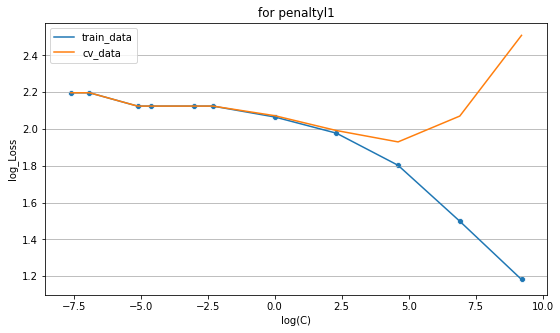

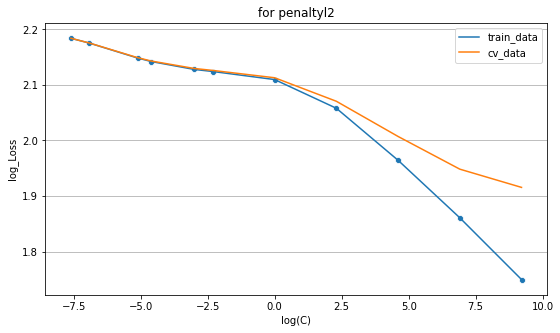

In [161]:
htune_logr(X_tr1,y_tr1,3)

In [162]:
print("The optimal C is {} \nRegularization is {}".format(100,'l2'))

The optimal C is 100 
Regularization is l2


Train Log Loss is  1.9541478975792423
Test Log loss is  1.9869903627328975


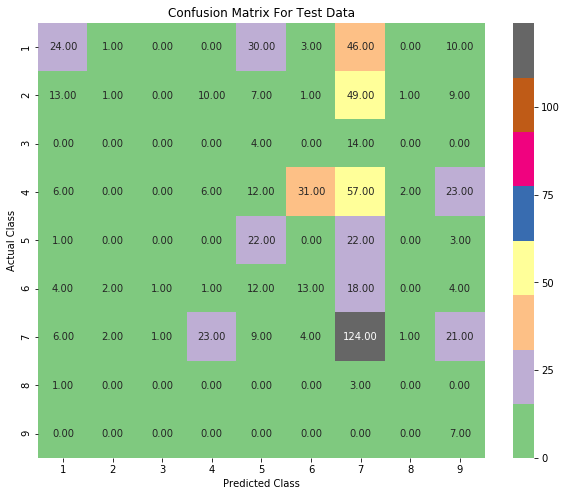

In [163]:
lr1=LogisticRegression(penalty='l2',C=100,class_weight='balanced',multi_class='ovr',fit_intercept=True,n_jobs=3)
lr1.fit(X_tr1,y_tr1)

print("Train Log Loss is ",log_loss(y_pred=lr1.predict_proba(X_tr1),y_true=y_tr1))
print("Test Log loss is ",log_loss(y_pred=lr1.predict_proba(X_ts1),y_true=y_ts1))

pltcnf(lr1,X_ts1,y_ts1)

#### >>Tfidf-Avgw2v of clinical text has produced even more worse results.It can be concluded that as compressing each clinical text to 300 dimensions we are losing some important information due to which model is performing worse.The clinical text is more scientific contains terminologies that are unsimilar,not like the case of Review text (reviews on items), Social media text (comments) etc which have a lot in common.

### 5. Conclusions

#### 1.We can apply more algorithms like Multinomial Naive Bayes,Support vector Machines and some  advanced algorithms like ensemble models ,LSTM's to improve the multiclass log-loss.
#### 2.As most of the predictions for class 2 are predicted as class 7, featurizations can be added which will help to distinguish between class 2 and class 7 and will improve the multiclass log-loss value.